In [1]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch import nn, einsum

from einops import rearrange

In [3]:
# helpers

def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

# classes

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

# attention

class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim = -1)
        return x * F.gelu(gates)

class FeedForward(nn.Module):
    def __init__(self, dim, mult = 4, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult * 2),
            GEGLU(),
            nn.Dropout(dropout),
            nn.Linear(dim * mult, dim)
        )

    def forward(self, x, **kwargs):
        return self.net(x)

class Attention(nn.Module):
    def __init__(
        self,
        dim,
        heads = 8,
        dim_head = 16,
        dropout = 0.
    ):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Linear(inner_dim, dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h = self.heads
        q, k, v = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), (q, k, v))
        sim = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = sim.softmax(dim = -1)
        attn = self.dropout(attn)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)', h = h)
        return self.to_out(out)

# transformer

class Transformer(nn.Module):
    def __init__(self, num_tokens, dim, depth, heads, dim_head, attn_dropout, ff_dropout):
        super().__init__()
        self.embeds = nn.Embedding(num_tokens, dim)
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = attn_dropout))),
                Residual(PreNorm(dim, FeedForward(dim, dropout = ff_dropout))),
            ]))

    def forward(self, x):
        x = self.embeds(x)

        for attn, ff in self.layers:
            x = attn(x)
            x = ff(x)

        return x
# mlp

class MLP(nn.Module):
    def __init__(self, dims, act = None):
        super().__init__()
        dims_pairs = list(zip(dims[:-1], dims[1:]))
        layers = []
        for ind, (dim_in, dim_out) in enumerate(dims_pairs):
            is_last = ind >= (len(dims_pairs) - 1)
            linear = nn.Linear(dim_in, dim_out)
            layers.append(linear)

            # removed last layer to get logits
            # if is_last:
            #     continue

            # act = default(act, nn.ReLU())
            # layers.append(act)

        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

# main class

class TabTransformer(nn.Module):
    def __init__(
        self,
        *,
        categories,
        num_continuous,
        dim,
        depth,
        heads,
        dim_head = 16,
        dim_out = 1,
        mlp_hidden_mults = (4, 2),
        mlp_act = None,
        num_special_tokens = 2,
        continuous_mean_std = None,
        attn_dropout = 0.,
        ff_dropout = 0.
    ):
        super().__init__()
        assert all(map(lambda n: n > 0, categories)), 'number of each category must be positive'

        # categories related calculations

        self.num_categories = len(categories)    # len of input sequences
        self.num_unique_categories = sum(categories)    # number of all categories

        # create category embeddings table

        self.num_special_tokens = num_special_tokens    # for missing?
        total_tokens = self.num_unique_categories + num_special_tokens

        # for automatically offsetting unique category ids to the correct position in the categories embedding table

        categories_offset = F.pad(torch.tensor(list(categories)), (1, 0), value = num_special_tokens)    # ??
        categories_offset = categories_offset.cumsum(dim = -1)[:-1]    # cumulative sum
        self.register_buffer('categories_offset', categories_offset)    # save it and use in forward

        # continuous

        if exists(continuous_mean_std):
            assert continuous_mean_std.shape == (num_continuous, 2), f'continuous_mean_std must have a shape of ({num_continuous}, 2) where the last dimension contains the mean and variance respectively'
        self.register_buffer('continuous_mean_std', continuous_mean_std)

        self.norm = nn.LayerNorm(num_continuous)
        self.num_continuous = num_continuous

        # transformer

        self.transformer = Transformer(
            num_tokens = total_tokens,
            dim = dim,
            depth = depth,
            heads = heads,
            dim_head = dim_head,
            attn_dropout = attn_dropout,
            ff_dropout = ff_dropout
        )

        # mlp to logits

        input_size = (dim * self.num_categories) + num_continuous
        l = input_size // 8

        hidden_dimensions = list(map(lambda t: l * t, mlp_hidden_mults))
        all_dimensions = [input_size, *hidden_dimensions, dim_out]

        self.mlp = MLP(all_dimensions, act = mlp_act)

    def forward(self, x_categ, x_cont):
        assert x_categ.shape[-1] == self.num_categories, f'you must pass in {self.num_categories} values for your categories input'
        x_categ += self.categories_offset

        x = self.transformer(x_categ)

        flat_categ = x.flatten(1)    # ?

        assert x_cont.shape[1] == self.num_continuous, f'you must pass in {self.num_continuous} values for your continuous input'

        if exists(self.continuous_mean_std):
            mean, std = self.continuous_mean_std.unbind(dim = -1)    # splits tensor into 2 parts
            x_cont = (x_cont - mean) / std

        normed_cont = self.norm(x_cont)    # norm over all batch

        x = torch.cat((flat_categ, normed_cont), dim = -1)
        return self.mlp(x)



# additional funcs

In [4]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt

In [5]:
class my_dataset(Dataset):
    def __init__(self, X1, X2, y):
        self.X1 = X1
        self.X2 = X2
        self.y = y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.y[idx]

def my_train_test_split(X1, X2, y, test_size=0.2, val_size=0.05, random_state=None):
    # X1 - categorical, X2 - continious, y - labels
    assert X1.shape[0] == X2.shape[0] == y.shape[0]
    n1 = int(np.around(test_size * y.shape[0]))
    n2 = int(np.around((val_size + test_size) * y.shape[0]))
    if random_state is not None:
        np.random.seed(seed)

    idx = np.random.permutation(y.shape[0])

    X1_test = X1[idx][:n1]
    X2_test = X2[idx][:n1]
    y_test = y[idx][:n1]

    X1_val = X1[idx][n1:n2]
    X2_val = X2[idx][n1:n2]
    y_val = y[idx][n1:n2]

    X1_train = X1[idx][n2:]
    X2_train = X2[idx][n2:]
    y_train = y[idx][n2:]

    return X1_train, X2_train, y_train, X1_val, X2_val, y_val, X1_test, X2_test, y_test

seed = 42


def single_pass(model, dataloader, loss, device, optim=None):
    loss_count, acc_count = 0, 0
    for i, (x_categ, x_cont, labels) in enumerate(dataloader):
        x_categ, x_cont, labels = x_categ.long().to(device), x_cont.float().to(device), labels.float().to(device)
        pred = model.forward(x_categ, x_cont)
        loss = F.binary_cross_entropy_with_logits(pred, labels)
        loss_count += loss.item() / len(dataloader)
        acc_count += (torch.round(nn.Sigmoid()(pred)) == labels).sum().float().item() / labels.shape[0]/len(dataloader)
        if optim is not None:
            loss.backward()
            optim.step()
    return loss_count, acc_count


# main

In [6]:
def main(filename):
    path = os.path.join('/content/drive/MyDrive/HSE/NIR/', filename)
    data_categ = pd.read_csv(os.path.join(path, 'categ.csv')).to_numpy()
    data_cont = pd.read_csv(os.path.join(path, 'cont.csv')).to_numpy()
    data_labels = pd.read_csv(os.path.join(path, 'labels.csv')).to_numpy()
    # print(data_cont.shape)

    X1_train, X2_train, y_train, X1_val, X2_val, y_val, X1_test, X2_test, y_test = my_train_test_split(data_categ,
                                                                                                       data_cont,
                                                                                                       data_labels,
                                                                                                       test_size=0.2,
                                                                                                       val_size=0.05,
                                                                                                       random_state=seed)

    cont_mean_std = np.array([X2_train.mean(axis=0), X2_train.std(axis=0)]).transpose(1, 0)
    cont_mean_std = torch.Tensor(cont_mean_std)

    categories = tuple(len(np.unique(data_categ[:, i])) for i in range(data_categ.shape[1]))

    model = TabTransformer(
        categories=categories,  # tuple containing the number of unique values within each category
        num_continuous=data_cont.shape[-1],  # number of continuous values
        dim=32,  # dimension, paper set at 32
        dim_out=1,  # binary prediction, but could be anything
        depth=6,  # depth, paper recommended 6
        heads=8,  # heads, paper recommends 8
        attn_dropout=0.1,  # post-attention dropout
        ff_dropout=0.1,  # feed forward dropout
        mlp_hidden_mults=(4, 2),  # relative multiples of each hidden dimension of the last mlp to logits
        mlp_act=None,  # activation for final mlp, defaults to relu, but could be anything else (selu etc)
        continuous_mean_std=cont_mean_std   # (optional) - normalize the continuous values before layer norm
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    batch_size = 2048
    epochs = 10
    lr = 1e-4
    optim = Adam(model.parameters(), lr=lr)
    loss = F.binary_cross_entropy_with_logits

    dataset_train = my_dataset(X1_train, X2_train, y_train)
    dataset_val = my_dataset(X1_val, X2_val, y_val)
    dataset_test = my_dataset(X1_test, X2_test, y_test)

    train_loss_all, val_loss_all, train_acc_all, val_acc_all = [], [], [], []
    # training loop
    for epoch in range(epochs):
      
        # train
        dataloader_train = DataLoader(dataset_train, batch_size=batch_size)
        train_loss, train_acc = single_pass(model, dataloader_train, loss, device, optim)

        # validation
        dataloader_val = DataLoader(dataset_val, batch_size=64)
        with torch.no_grad():
            val_loss, val_acc = single_pass(model, dataloader_val, loss, device)
        
        print(f'epoch {epoch}, train_loss={train_loss}, validation_loss={val_loss}, train_acc={train_acc}, val_acc={val_acc}')

        train_loss_all.append(train_loss)
        val_loss_all.append(val_loss)
        train_acc_all.append(train_acc)
        val_acc_all.append(val_acc)

    # test
    with torch.no_grad():
        dataloader_test = DataLoader(dataset_test, batch_size=64)
        test_loss, test_acc = single_pass(model, dataloader_test, loss, device)

        
        print(f'test_loss={test_loss}, test_acc={test_acc}')
    return train_loss_all, val_loss_all, train_acc_all, val_acc_all, test_loss, test_acc


In [7]:
def plot_results(ax, train_results: list, val_results: list, test_result, label):
    epochs = np.arange(1, len(train_results) + 1)
    ax.plot(epochs, train_results, label='train')
    ax.plot(epochs, val_results, label='validation')
    ax.plot(epochs[-1], test_result,
            marker='o', linestyle='none', label='test')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(label)
    ax.grid(linestyle=':')
    ax.legend()

In [8]:
# if __name__ == '__main__':
train_loss, val_loss, train_acc, val_acc, test_loss, test_acc = main('seismic_bumps')


epoch 0, train_loss=0.7065544724464417, validation_loss=0.7041756510734558, train_acc=0.5030959752321982, val_acc=0.3645833333333333
epoch 1, train_loss=0.6679652333259583, validation_loss=0.6616597572962443, train_acc=0.6062951496388029, val_acc=0.453125
epoch 2, train_loss=0.6325032711029053, validation_loss=0.6248822410901388, train_acc=0.7244582043343654, val_acc=0.859375
epoch 3, train_loss=0.5998178720474243, validation_loss=0.5909220774968464, train_acc=0.8013415892672858, val_acc=0.890625
epoch 4, train_loss=0.5693876147270203, validation_loss=0.5610341429710388, train_acc=0.8570691434468525, val_acc=0.9270833333333333
epoch 5, train_loss=0.5391197204589844, validation_loss=0.5285149415334066, train_acc=0.8931888544891641, val_acc=0.9427083333333333
epoch 6, train_loss=0.5119954347610474, validation_loss=0.5005035996437073, train_acc=0.9215686274509803, val_acc=0.9479166666666665
epoch 7, train_loss=0.4854819178581238, validation_loss=0.46790007750193274, train_acc=0.9267285861

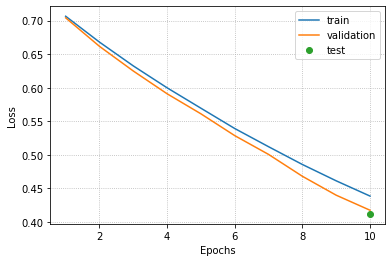

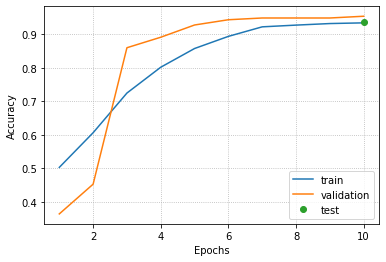

In [9]:
_, ax1 = plt.subplots()
plot_results(ax1, train_loss, val_loss, test_loss, 'Loss')
plt.show()
_, ax2 = plt.subplots()
plot_results(ax2, train_acc, val_acc, test_acc, 'Accuracy')
plt.show()